In [ ]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from matplotlib import pyplot as plt, cm

from common import dalt
from common import hallmark as hm
from common import viz
from common.shadow import *
from common import analyses as nn

In [237]:
pf = hm.ParaFrame('cache/SPO2023/avg/{NGC}_a{aspin:g}_i{inc:g}_f{freq}.h5')
pf_summ = hm.ParaFrame('cache/SPO2023/summ1/{NGC}_a{aspin:g}_i{inc:g}_{freq}.tsv')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

freq = ['86.e9', '230.e9', '345.e9']

freq ['230.e9' '345.e9' '86.e9']
inc [ 50. 160.]
NGC ['NGC3998' 'NGC4261' 'NGC4594']
aspin [-0.94 -0.5   0.    0.5   0.94]


In [ ]:
for a in aspin:
    if a != 0:
        x, y = shadow(a, 160*np.pi/180)
        x, y = np.ma.masked_array(x, np.isnan(y)), np.ma.masked_array(y, np.isnan(y))
        plt.plot(x, y, label=a)
        cx, cy = np.average(x), np.average(y)
        plt.scatter(cx, cy)
        print(a, np.max(x-cx))
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')

In [ ]:
MUI, MUJ = np.meshgrid(np.linspace(-25, 25), np.linspace(-25, 25))
plt.plot(MUI, MUJ)
cx, cy = 5, 10
MUDISTS = np.sqrt(np.power(MUI-cx,2.)+np.power(MUJ-cy,2.))
plt.scatter(MUI[MUDISTS < 10], MUJ[MUDISTS < 10])
plt.gca().set_aspect('equal')

In [ ]:
def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
    return dalt.Image(data, meta=meta)

def quiver(img, ax):
    extent = img.extent
    img = np.flipud(img.transpose((1,0,2)))
    npix = img[:,:,0].shape[0]
    I = img[:,:,0].value
    Q = img[:,:,1].value
    U = img[:,:,2].value
    evpa = (180./3.14159)*0.5*np.arctan2(U,Q)

    xs = np.linspace(extent[0], extent[1], npix)
    Xs,Ys = np.meshgrid(xs,xs)
    lpscal = np.max(np.sqrt(Q*Q+U*U))

    vxp = np.sqrt(Q*Q+U*U)*np.sin(evpa*3.14159/180.)/lpscal
    vyp = -np.sqrt(Q*Q+U*U)*np.cos(evpa*3.14159/180.)/lpscal
    skip = int(npix/32)  
    #ax.imshow(img[:,:,0].value,extent=extent, cmap='afmhot')
    ax.quiver(Xs[::skip,::skip],Ys[::skip,::skip],vxp[::skip,::skip],vyp[::skip,::skip], 
        headwidth=1, headlength=1, 
        width=0.005,
        color='#00ff00', 
        units='width', 
        scale=4,
        pivot='mid',)

def colorbar(mappable):
  """ the way matplotlib colorbar should have been implemented """
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  ax = mappable.axes
  fig = ax.figure
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  return fig.colorbar(mappable, cax=cax)

def linfrac(img, ax):
    extent = img.extent
    img = np.flipud(img.transpose((1,0,2)))
    I = img[:,:,0].value
    Q = img[:,:,1].value
    U = img[:,:,2].value

    Imaskval = np.abs(I.min()) * 100.
    Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)

    ax.set_facecolor('black')

    lpfrac = 100.*np.sqrt(Q*Q+U*U)/I
    lpfrac[np.abs(I)<Imaskval] = np.nan
    im = ax.imshow(lpfrac, cmap='jet', vmin=0., vmax=100, extent=extent)
    colorbar(im)

def cirfrac(img, ax):
    extent = img.extent
    img = np.flipud(img.transpose((1,0,2)))
    I = img[:,:,0].value
    V = img[:,:,3].value

    Imaskval = np.abs(I.min()) * 100.
    Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)

    cpfrac = 100.*V/I
    cpfrac[np.abs(I)<Imaskval] = np.nan
    vext = max(np.abs(np.nanmin(cpfrac)),np.abs(np.nanmax(cpfrac)))
    vext = max(vext, 1.)
    if np.isnan(vext): vext = 10.
    ax.set_facecolor('black')
    im = ax.imshow(cpfrac, cmap='seismic', vmin=-vext, vmax=vext, origin='lower', extent=extent)
    colorbar(im)

def findring(img, ax, a, i, obj):
    rindrad = {'NGC4594': 7, 'NGC3998': 6.2, 'NGC4261': 5.6}
    MUI, MUJ = np.meshgrid(np.linspace(-25, 25), np.linspace(-25, 25))
    if a != 0:
        x, y = shadow(a, i*np.pi/180)
        x, y = np.ma.masked_array(x, np.isnan(y)), np.ma.masked_array(y, np.isnan(y))
        cx, cy = np.average(x), np.average(y)
        r = np.max(x-cx)
    else:
        cx, cy = 0, 0
        r = rindrad[obj]
    cir = plt.Circle((-cx, cy), r, fill=False, color='b')
    ax.add_artist(cir)
    MUDISTS = np.sqrt(np.power(MUI-(-cx),2.)+np.power(MUJ-cy,2.))
    #ax.plot(MUI[MUDISTS < r], MUJ[MUDISTS < r])

from matplotlib.patches import Ellipse
def ellipse(img, ax):
    _, alpha0, beta0, major_PWHM, minor_PWHM, PA = nn.moments(img.value, *img.fov.value, FWHM=True)

    ellipse = Ellipse(
        xy = (alpha0, beta0),
        width=minor_PWHM,
        height=major_PWHM,
        angle=-PA,
        facecolor='none',
        edgecolor='b'
    )
    ax.add_patch(ellipse)
    ax.scatter(alpha0, beta0)


In [ ]:
def plot(ax, pf):
    if len(pf) != 1:
        return
    
    if pf.freq.iloc[0] == '230GHz':
        vmax = .75e-3
    else:
        vmax = None    

    img = readimg(pf.path.iloc[0])
    viz.show(img, s=0, ax=ax, vmin=0, vmax=vmax, labels=False, cmap='afmhot')
    #quiver(img, ax)
    #findring(img, ax, pf.aspin.iloc[0], pf.inc.iloc[0], pf.NGC.iloc[0])
    ellipse(img, ax)

    ax.xaxis.set_ticks(np.linspace(-25,25,5))
    ax.yaxis.set_ticks(np.linspace(-25,25,5))
    ax.tick_params(color='w')
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

for obj in NGC:
    for i in inc:
        fig = viz.grid(pf(NGC=obj)(inc=i), plot, aspin=aspin, freq=freq,
                        figsize=(10,10), title=f'Avg image of {obj} with $i$={i}',
                        xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                        xlabel=r'$x$ [$\mu$as]', ylabel=r'$y$ [$\mu$as]', )
                        #fout=f'output/plot/test/{}_{}'.forma2322t(a,freq))
plt.show()
plt.close(fig)

In [ ]:
def cirplot(ax, pf):
    if len(pf) != 1:
        return
    
    if pf.freq.iloc[0] == '230GHz':
        vmax = .75e-3
    else:
        vmax = None    

    img = readimg(pf.path.iloc[0])
    #viz.show(img, s=1, ax=ax, vmin=0, vmax=vmax, labels=False)
    #quiver(img, ax)
    cirfrac(img, ax)

    ax.xaxis.set_ticks(np.linspace(-25,25,5))
    ax.yaxis.set_ticks(np.linspace(-25,25,5))
    ax.tick_params(color='w')
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

for obj in NGC:
    for i in inc:
        fig = viz.grid(pf(NGC=obj)(inc=i), cirplot, aspin=aspin, freq=freq,
                        figsize=(10,10), title=f'Avg image of {obj} with $i$={i}',
                        xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                        xlabel=r'$x$ [$\mu$as]', ylabel=r'$y$ [$\mu$as]', )
                        #fout=f'output/plot/test/{}_{}'.format(a,freq))
plt.show()
plt.close(fig)

In [ ]:
def linplot(ax, pf):
    if len(pf) != 1:
        return
    
    if pf.freq.iloc[0] == '230GHz':
        vmax = .75e-3
    else:
        vmax = None    

    img = readimg(pf.path.iloc[0])
    #viz.show(img, s=1, ax=ax, vmin=0, vmax=vmax, labels=False)
    #quiver(img, ax)
    linfrac(img, ax)

    ax.xaxis.set_ticks(np.linspace(-25,25,5))
    ax.yaxis.set_ticks(np.linspace(-25,25,5))
    ax.tick_params(color='w')
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

for obj in NGC:
    for i in inc:
        fig = viz.grid(pf(NGC=obj)(inc=i), linplot, aspin=aspin, freq=freq,
                        figsize=(10,10), title=f'Avg image of {obj} with $i$={i}',
                        xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                        xlabel=r'$x$ [$\mu$as]', ylabel=r'$y$ [$\mu$as]', )
                        #fout=f'output/plot/test/{}_{}'.format(a,freq))
plt.show()
plt.close(fig)

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

4
4
4


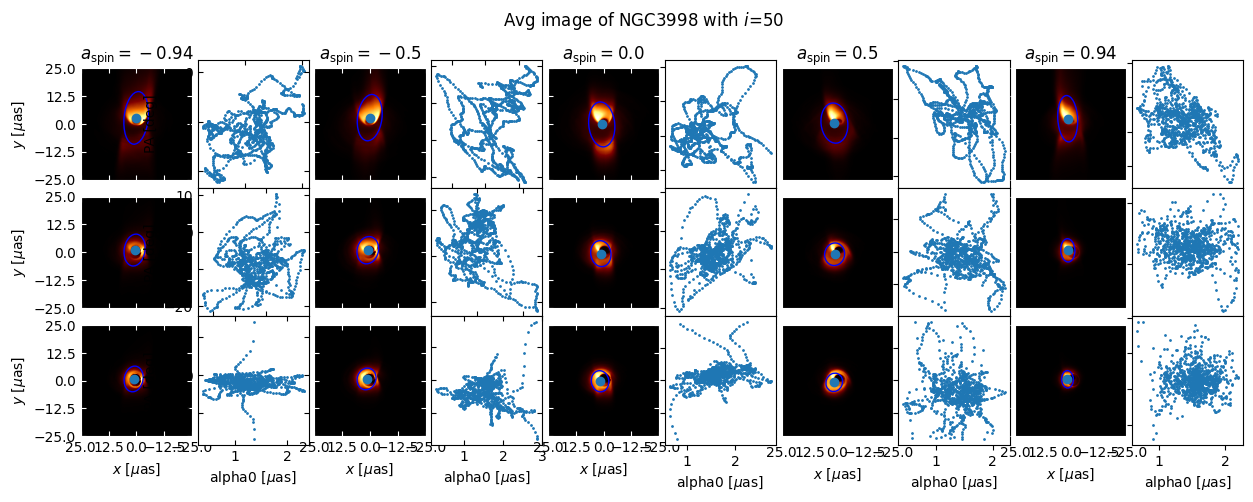

In [278]:
x = 'alpha0'
y = 'PA'
def plot(ax, pf):
    '''
    Plot the intensity image
    '''
    if len(pf) != 1:
        return
    
    if pf.freq.iloc[0] == '230GHz':
        vmax = .75e-3
    else:
        vmax = None    

    img = readimg(pf.path.iloc[0])
    viz.show(img, s=0, ax=ax, vmin=0, vmax=vmax, labels=False, cmap='afmhot', aspect='equal')
    #quiver(img, ax)
    #findring(img, ax, pf.aspin.iloc[0], pf.inc.iloc[0], pf.NGC.iloc[0])
    ellipse(img, ax)

    ax.xaxis.set_ticks(np.linspace(-25,25,5))
    ax.yaxis.set_ticks(np.linspace(-25,25,5))
    ax.tick_params(color='w')
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

def check_rel(ax, pf):
    df = pd.read_csv(pf_summ(aspin=pf.aspin.iloc[0])(freq=pf.freq.iloc[0])(inc=pf.inc.iloc[0])(NGC=pf.NGC.iloc[0]).path.iloc[0], sep='\t')
    ax.scatter(df[x], df[y], s=1)

def grid(pf, plot,
         fout   = None,
         title  = None,
         rowmap = None,
         colmap = None,
         xtitle = None,
         ytitle = None,
         xlabel = None,
         ylabel = None,
         xspace = 0.05,
         yspace = 0,
         legend = None,
         **kwargs):

    keys   = list(kwargs.keys())
    colkey = keys[0]
    cols   = kwargs.pop(keys[0])
    rowkey = keys[1]
    rows   = kwargs.pop(keys[1])

    fig, axes = plt.subplots(len(rows), len(cols)*2, **kwargs)
    if len(rows) == 1:
        axes = [axes]
    if len(cols) == 1:
        axes = [[a] for a in axes]

    for i, c in enumerate(cols):
        for j, r in enumerate(rows):
            plot[0](axes[j][i*2], pf(**{colkey:c})(**{rowkey:r}))
            plot[1](axes[j][i*2+1], pf(**{colkey:c})(**{rowkey:r}))

            if i == 0:
                axes[j][i*2].set_ylabel(ylabel[0])
                axes[j][i*2+1].set_ylabel(ylabel[1])
            else:
                axes[j][i*2].set_yticklabels([])
                axes[j][i*2+1].set_yticklabels([])

            if i == len(cols)-1 and ytitle is not None:
                print(i)
                ax_r = axes[j][i*2-1] #ax_r = axes[j][i].twinx()
                ax_r.yaxis.set_label_position("right")
                if rowmap is not None:
                    ax_r.set_ylabel(ytitle.format(rowmap[r]))
                else:
                    ax_r.set_ylabel(ytitle.format(r))

            if j == 0 and xtitle is not None:
                if colmap is not None:
                    axes[j][i].set_title(xtitle.format(colmap[c]))
                else:
                    axes[j][i*2].set_title(xtitle.format(c))

            if j == len(rows)-1:
                axes[j][i*2].set_xlabel(xlabel[0])
                axes[j][i*2+1].set_xlabel(xlabel[1])
            else:
                axes[j][i*2].set_xticklabels([])
                axes[j][i*2+1].set_xticklabels([])

            axes[j][i].tick_params(axis='both',
                                   direction='in',
                                   top=True,
                                   right=True)

    if legend is not None:
        axes[0][-1].legend(loc=legend)

    fig.suptitle(title)
    #fig.tight_layout()
    fig.subplots_adjust(wspace=xspace, hspace=yspace)
    if fout:
        fig.savefig(fout+'.pdf')
        #fig.savefig(fout+'.png', dpi=300)

    return fig

for obj in ['NGC3998']:
    for i in [50]:
        fig = grid(pf(NGC=obj)(inc=i), [plot, check_rel], aspin=aspin, freq=freq,
                        figsize=(15,5), title=f'Avg image of {obj} with $i$={i}',
                        xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                        xlabel=[r'$x$ [$\mu$as]', x+r' [$\mu$as]'], ylabel=[r'$y$ [$\mu$as]', y+r' [deg]'])
                        #fout=f'output/plot/test/{}_{}'.forma2322t(a,freq))
